In [69]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from skimage import color
from skimage.filters import gabor
from tqdm import tqdm

from utils.load_data import load_split
from utils.ml_training import plot_classification_metrics, plot_model_sizes, plot_training_times, run_ml_experiments
from utils.types import FeatureVector_float32, RGBImage_uint8


In [2]:
train_images, train_labels = load_split("data/train/", library="pil")
len(train_images), train_images[0].shape, train_labels.shape


Loading FAKE images: 100%|██████████| 50000/50000 [00:29<00:00, 1703.66it/s]


(100000, (32, 32, 3), (100000,))

In [3]:
test_images, test_labels = load_split("data/test/", library="pil")
len(test_images), test_images[0].shape, test_labels.shape


Loading FAKE images: 100%|██████████| 10000/10000 [00:06<00:00, 1434.80it/s]


(20000, (32, 32, 3), (20000,))

In [88]:
GABOR_FREQUENCIES = [0.2, 0.4]
GABOR_THETAS = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]


In [89]:
np.rad2deg(GABOR_THETAS)

array([  0.,  45.,  90., 135.])

In [93]:
def extract_gabor_feature(img: RGBImage_uint8, frequency: float, theta: float) -> tuple[float, float]:
    """Return stacked mean/std magnitudes of the configured Gabor responses."""
    gray = color.rgb2gray(img).astype(np.float32)

    real, imag = gabor(gray, frequency=frequency, theta=theta)
    magnitude = np.sqrt(real**2 + imag**2)

    return float(magnitude.mean()), float(magnitude.std())

In [94]:
import pandas as pd


def get_gabor_df(images: list[RGBImage_uint8]) -> pd.DataFrame:
    features = {}
    for frequency in GABOR_FREQUENCIES:
        for theta in GABOR_THETAS:
            means = []
            stds = []
            for img in tqdm(images, desc=f"Gabor freq={frequency} theta={np.rad2deg(theta)}"):
                mean, std = extract_gabor_feature(img, frequency, theta)
                means.append(mean)
                stds.append(std)
            features[f"gabor_f{frequency}_t{np.rad2deg(theta)}_mean"] = means
            features[f"gabor_f{frequency}_t{np.rad2deg(theta)}_std"] = stds
    return pd.DataFrame(features)

In [95]:
df_gabor_train = get_gabor_df(train_images)
df_gabor_test = get_gabor_df(test_images)

Gabor freq=0.4 theta=135.0: 100%|██████████| 20000/20000 [00:03<00:00, 5745.22it/s]


In [96]:
df_gabor_train["label"] = train_labels
df_gabor_test["label"] = test_labels

In [100]:
df_gabor_train.columns = df_gabor_train.columns.str.replace(".0_", "_")
df_gabor_test.columns = df_gabor_test.columns.str.replace(".0_", "_")

In [102]:
# make all features float32
for col in df_gabor_train.columns:
    if col != "label":
        df_gabor_train[col] = df_gabor_train[col].astype(np.float32)
        df_gabor_test[col] = df_gabor_test[col].astype(np.float32)

In [106]:
df_gabor_train

,gabor_f0.2_t0_mean,gabor_f0.2_t0_std,gabor_f0.2_t45_mean,gabor_f0.2_t45_std,gabor_f0.2_t90_mean,gabor_f0.2_t90_std,gabor_f0.2_t135_mean,gabor_f0.2_t135_std,gabor_f0.4_t0_mean,gabor_f0.4_t0_std,gabor_f0.4_t45_mean,gabor_f0.4_t45_std,gabor_f0.4_t90_mean,gabor_f0.4_t90_std,gabor_f0.4_t135_mean,gabor_f0.4_t135_std,label
0,0.025487,0.015180,0.015745,0.008965,0.035235,0.023189,0.017233,0.009223,0.014462,0.010695,0.010592,0.006646,0.021182,0.017255,0.012010,0.007830,0
1,0.010986,0.012186,0.012773,0.015618,0.022050,0.013359,0.015124,0.013296,0.008714,0.012276,0.006274,0.007100,0.011564,0.008165,0.009103,0.009235,0
2,0.016285,0.012491,0.013393,0.008042,0.017579,0.009739,0.013057,0.007870,0.011420,0.009930,0.008178,0.004998,0.009171,0.005822,0.009335,0.006005,0
3,0.010716,0.013054,0.010267,0.008752,0.022262,0.023039,0.009274,0.010089,0.005055,0.005926,0.004737,0.004743,0.010330,0.011244,0.004923,0.005105,0
4,0.010842,0.008827,0.007563,0.004795,0.013905,0.008357,0.008254,0.007586,0.009359,0.007253,0.006268,0.003545,0.006657,0.004499,0.005974,0.003613,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.025049,0.023709,0.010386,0.010362,0.018512,0.016688,0.012819,0.014602,0.014546,0.013666,0.006869,0.006157,0.013893,0.015813,0.008002,0.009398,1
99996,0.007965,0.009670,0.008950,0.012678,0.008978,0.010681,0.011538,0.014681,0.004960,0.007368,0.005335,0.007723,0.007333,0.011752,0.006975,0.009966,1
99997,0.022883,0.021229,0.016462,0.017172,0.017052,0.011470,0.013510,0.011879,0.013327,0.015917,0.010689,0.014874,0.013905,0.009374,0.008678,0.008679,1
99998,0.019635,0.024341,0.007484,0.009505,0.017972,0.023331,0.009134,0.009530,0.010233,0.013153,0.004244,0.005433,0.016788,0.025456,0.005581,0.006596,1


In [103]:
df_gabor_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gabor_f0.2_t0_mean    100000 non-null  float32
 1   gabor_f0.2_t0_std     100000 non-null  float32
 2   gabor_f0.2_t45_mean   100000 non-null  float32
 3   gabor_f0.2_t45_std    100000 non-null  float32
 4   gabor_f0.2_t90_mean   100000 non-null  float32
 5   gabor_f0.2_t90_std    100000 non-null  float32
 6   gabor_f0.2_t135_mean  100000 non-null  float32
 7   gabor_f0.2_t135_std   100000 non-null  float32
 8   gabor_f0.4_t0_mean    100000 non-null  float32
 9   gabor_f0.4_t0_std     100000 non-null  float32
 10  gabor_f0.4_t45_mean   100000 non-null  float32
 11  gabor_f0.4_t45_std    100000 non-null  float32
 12  gabor_f0.4_t90_mean   100000 non-null  float32
 13  gabor_f0.4_t90_std    100000 non-null  float32
 14  gabor_f0.4_t135_mean  100000 non-null  float32
 15  g

In [104]:
df_gabor_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gabor_f0.2_t0_mean    20000 non-null  float32
 1   gabor_f0.2_t0_std     20000 non-null  float32
 2   gabor_f0.2_t45_mean   20000 non-null  float32
 3   gabor_f0.2_t45_std    20000 non-null  float32
 4   gabor_f0.2_t90_mean   20000 non-null  float32
 5   gabor_f0.2_t90_std    20000 non-null  float32
 6   gabor_f0.2_t135_mean  20000 non-null  float32
 7   gabor_f0.2_t135_std   20000 non-null  float32
 8   gabor_f0.4_t0_mean    20000 non-null  float32
 9   gabor_f0.4_t0_std     20000 non-null  float32
 10  gabor_f0.4_t45_mean   20000 non-null  float32
 11  gabor_f0.4_t45_std    20000 non-null  float32
 12  gabor_f0.4_t90_mean   20000 non-null  float32
 13  gabor_f0.4_t90_std    20000 non-null  float32
 14  gabor_f0.4_t135_mean  20000 non-null  float32
 15  gabor_f0.4_t135_std

In [105]:
df_gabor_train.to_csv("data/gabor_features_train.csv", index=False)
df_gabor_test.to_csv("data/gabor_features_test.csv", index=False)

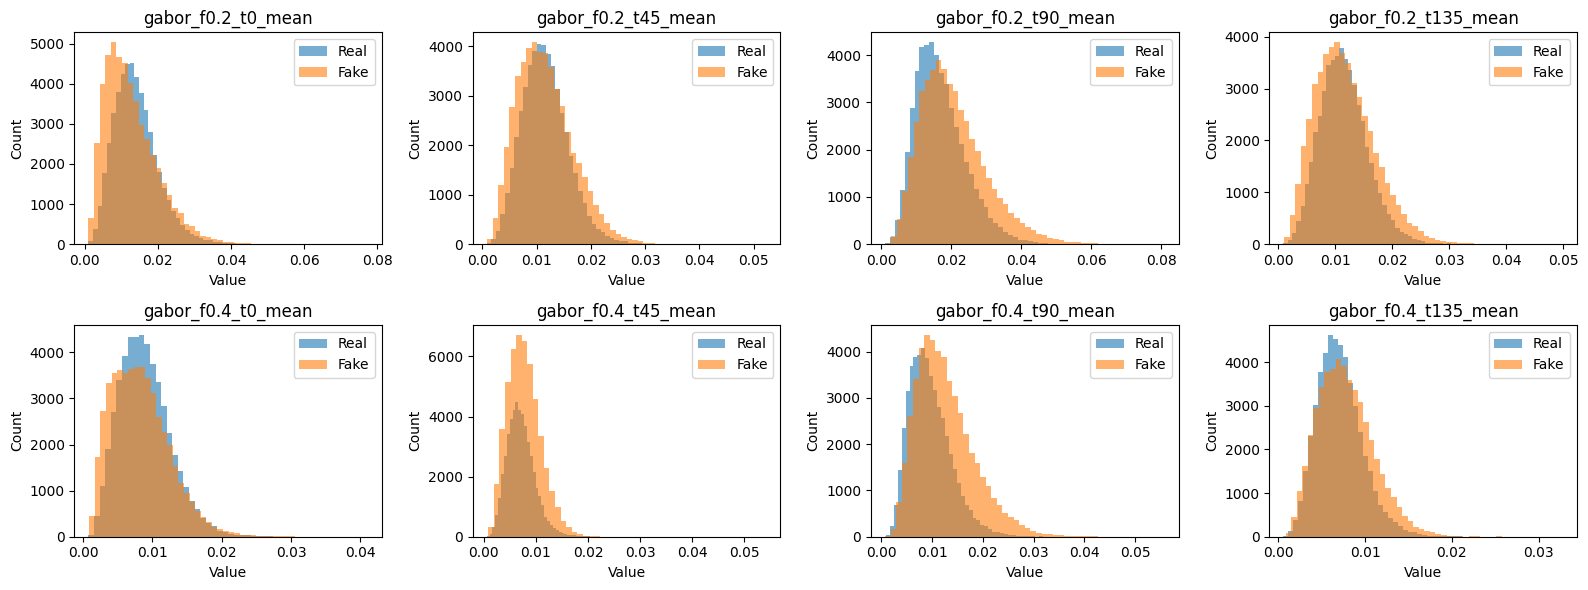

In [112]:
feature_cols = [col for col in df_gabor_train.columns if col != "label"]

mean_feature_cols = [col for col in feature_cols if "mean" in col]
n_feats = len(mean_feature_cols)
n_cols = 4
n_rows = int(np.ceil(n_feats / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, feat in enumerate(mean_feature_cols):
    ax = axes[i]
    ax.hist(df_gabor_train[df_gabor_train["label"] == 0][feat], bins=50, alpha=0.6, label="Real")
    ax.hist(df_gabor_train[df_gabor_train["label"] == 1][feat], bins=50, alpha=0.6, label="Fake")
    ax.set_title(feat)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()


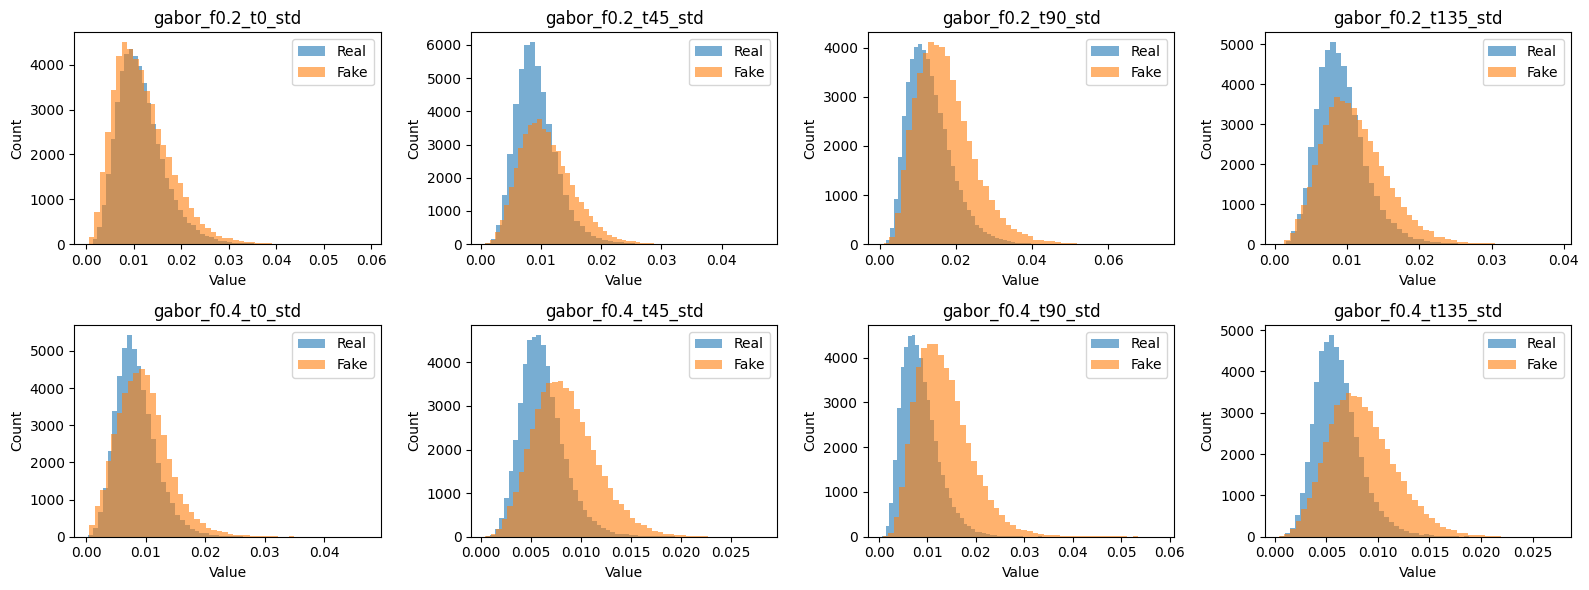

In [113]:
std_feature_cols = [col for col in feature_cols if "std" in col]
n_feats = len(std_feature_cols)
n_cols = 4
n_rows = int(np.ceil(n_feats / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, feat in enumerate(std_feature_cols):
    ax = axes[i]
    ax.hist(df_gabor_train[df_gabor_train["label"] == 0][feat], bins=50, alpha=0.6, label="Real")
    ax.hist(df_gabor_train[df_gabor_train["label"] == 1][feat], bins=50, alpha=0.6, label="Fake")
    ax.set_title(feat)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()